In [1]:

import pyemma
from sklearn.decomposition import PCA
import MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis import align

import nglview as nv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm
import matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/usr/local/Caskroom/miniconda/base/envs/charm38/lib/python3.8/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


In [2]:
plt.rcParams['axes.labelpad'] = 3.
plt.rcParams['font.size'] = 30
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 25
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['figure.autolayout'] = True



# Context
This notebook is distributed as part of the article:

**Turning Up the Heat Mimics Allosteric Signaling in Imidazole-Glycerol Phosphate Synthase.**

by *Federica Maschietto, Uriel N. Morzan, Florentina Tofoleanu, Aria Gheeraert, Apala Chaudhuri, Gregory W. Kyro, Peter Nekrasov, Bernard Brooks, J. Patrick Loria, Ivan Rivalta, Victor S. Batista*

The following analysis can be used to reproduce the analysis described in section *Temperature induced adaptation of essential dynamics* of the article.


In [ ]:
# CHANGE PATH ACCORDINGLY:
# trajectories can be downloaded at the following link:
# https://drive.google.com/drive/folders/1yc5vzhWw_NZ_C34QfC34-JpArE8SUKIV?usp=sharing

# change to the appropriate /path/to/drive/
p2d = '.'


path_traj =  p2d + '/TRAJECTORIES/'

# path to output directory, change accordingly
path =  './'


#   Temperature and effector induced adaptation of essential dynamics

* The unbound trajectory started at $T=30˚$ is referred to as APO30 

* The unbound trajectory started at $T=50˚$ is referred to as APO50

* The bound trajectory started at $T=30˚$ is referred to as   HOLO30

In [6]:
# PREP is set to False. This avoids re-aligning the trajectories. 
# No need to run, aligned trajectories are stored in the trajectories folder. 


PREP = False

def prepare(topo, traj, topo_ref, traj_ref, selstring):
    """ align trajectory to a reference """
    universe = MDAnalysis.Universe(topo, traj)
    uniref = MDAnalysis.Universe(topo_ref, traj_ref)
    atomgroup = universe.select_atoms(selstring)
    prealigner = align.AlignTraj(universe, uniref, select="backbone", in_memory=True).run()
    reference_coordinates = uniref.trajectory.timeseries(asel=atomgroup).mean(axis=1)
    reference = MDAnalysis.Merge(atomgroup).load_new(reference_coordinates[None, :, :], order="fac")
    aligner = align.AlignTraj(universe, reference, select=selstring, in_memory=True).run()
    return universe

if PREP:
    
    # load APO30 trajectory
    t30a = path_traj + '30A-stride50.dcd'
    # load APO50 trajectory
    t50a = path_traj + '50A-stride50.dcd'
    # load HOLO30 trajectory
    t30h = path_traj + '30H-stride50.dcd'

    #load trajectories using mdtraj
    pdbholo  = path_traj + '30H_frame0.pdb'
    pdbapo30 = path_traj + '30A_frame0.pdb'
    pdbapo50 = path_traj + '50A_frame0.pdb'

    # load and align all to a single reference using backbone atoms
    ut30a = prepare(pdbapo30, t30a, pdbapo30, t30a, 'backbone')
    ut30h = prepare(pdbholo,  t30h, pdbapo30, t30a, 'backbone')
    ut50a = prepare(pdbapo50, t50a, pdbapo30, t30a, 'backbone')


    # save aligned trajectories for later use
    with MDAnalysis.Writer(path + "t30a_aligned.dcd", ut30a.atoms.n_atoms) as W:
        for ts in ut30a.trajectory[0::10]:
            W.write(ut30a.atoms)
    W.close()
    ut30a.trajectory[0]
    with MDAnalysis.Writer(path + "t30a_aligned.pdb", ut30a.atoms.n_atoms) as W:
        W.write(ut30a.atoms)
    W.close()


    with MDAnalysis.Writer(path + "t50a_aligned.dcd", ut50a.atoms.n_atoms) as W:
        for ts in ut50a.trajectory[0::10]:
            W.write(ut50a.atoms)
    W.close()
    ut50a.trajectory[0]
    with MDAnalysis.Writer(path + "t50a_aligned.pdb", ut50a.atoms.n_atoms) as W:
        W.write(ut50a.atoms)
    W.close()


    with MDAnalysis.Writer(path + "t30h_aligned.dcd", ut30h.atoms.n_atoms) as W:
        for ts in ut30h.trajectory[0::10]:
            W.write(ut30h.atoms)
    W.close()
    ut30h.trajectory[0]
    with MDAnalysis.Writer(path +"t30h_aligned.pdb", ut30h.atoms.n_atoms) as W:
        W.write(ut30h.atoms)
    W.close()


In [7]:
path2traj = path_traj # change accordingly


outpath = path 
figpath = path 

# load trajectories already aligned (mean free coordinates)
ut30h = mda.Universe(path2traj + 't30h_aligned.pdb', path2traj + 't30h_aligned.dcd')
ut30a = mda.Universe(path2traj + 't30a_aligned.pdb', path2traj + 't30a_aligned.dcd')
ut50a = mda.Universe(path2traj + 't50a_aligned.pdb', path2traj + 't50a_aligned.dcd')


In [8]:
# globals
ncomp = None
whiten = False
SAVETRAJ = True
z_score = False
fn_weighted_avg = lambda x: x / x.sum()

##  Principal Component analysis (PCA)

The DimRed class computes the PCA transformation of a given trajectory. 
Visualizing the motion (projections) of selected components into a reduced dimensional space can be done by transform a given atom group into weights $\bar{w}_i$ over each principal component $n_i$.

$$w_{n}(t)=(r(t)−\bar{r})⋅u_n, \ \ \ u_n = \sum_{i}^{N} u_i)$$

$r(t)$ are the atom group coordinates at time $t$, $\bar{r}$ are the mean coordinates used in the PCA, and $\sum_{i}^{N}u_n$ is the sum over the $N$ selected principal component eigenvectors $u$.


Secondly we project the original trajectory onto each of the principal components, to visualise the motion of each of a combination thereof.
The projected trajectory r_n(t) represents the fluctuations from the mean positions $\bar{r}$.

$$ r_n(t)=w_n(t) \times u_n+\bar{r}$$


In [6]:
class DimRed():
    """Perform Principal component analysis of a given trajectory """
    def __init__(self):
        self.pca = None
        self.transformed = None
        
        self.pc = None
        self.trans = None
        self.coor = None
        self.proj = None
        self.ncomp = 0
        self.ndim  = 0
        self.data = None
    
    def load_data(self, data):
        self.data = data

    def dimreduction(self, topo, traj, selection='protein and name C CA N', ndim=10, ncomp=2, whiten=False, z_score=False, savetraj=True,
                     savepdbtraj=False, save='./'):
        self.topo = topo
        self.traj = traj
        self.ndim = ndim
        self.ncomp = ncomp
        
        
        fn_weighted_avg = lambda x: x / x.sum()
        
        u = mda.Universe(topo, traj)
        feat = pyemma.coordinates.featurizer(topo)
        backbone = feat.select(selection)
        feat.add_selection(backbone)
        if self.data is None:
            self.data = pyemma.coordinates.load([traj], features=feat) * 10
        
        if z_score:
            print('@> standardize the data')
            funz_z_score = lambda x: (x - x.mean()/x.std())
            self.data = funz_z_score(self.data)
        else:
            print('@> assuming data is already mean free')

        # compute pca
        print('@> compute pca')
        self.pca = pyemma.coordinates.pca(self.data, dim=ndim)

        if whiten:
            # eigenvectors are multiplied by the square root of n_samples and then divided by the eigenvalues
            # to ensure uncorrelated outputs with unit component-wise variances.
            eigenvectors = self.pca.eigenvectors * np.sqrt(self.data.shape[1]) / self.pca.eigenvalues
        else:
            eigenvectors = self.pca.eigenvectors
        # fit transform
        print('@> fit transform')
        self.transformed = self.pca.fit_transform(self.data)
        # store first principal component
        print('@> store first pc')
        self.pc= np.sum(eigenvectors[:, 0:ncomp], axis=1)
        # store transformed coordinates
        print('@> store transformed coord')
        self.trans =  np.sum(self.transformed[:, 0:ncomp], axis=1)
        # project transformed coordinates
        self.projected= np.outer(self.trans, self.pc) + self.data.mean(axis=0)
        print('@> total variance described by first %d components' %ncomp, np.sum(fn_weighted_avg(self.pca.eigenvalues)[0:ncomp]))
        # reshape coordinates
        print('@> reshape coordinates')
        self.coor = self.projected.reshape((len(self.trans), -1, 3))
        # load coordinates to universe
        print('@> load coordinates into universe')
        self.proj = mda.Merge(u.select_atoms('protein and name C CA N'))
        self.proj.load_new(self.coor, order="fac")
        if savetraj:
            print('@> save trajectory')
            with MDAnalysis.Writer(save + ".dcd", self.proj.atoms.n_atoms) as W:
                for ts in self.proj.trajectory:
                    W.write(self.proj.atoms)
            W.close()
            self.proj.trajectory[0]
            if savepdbtraj:
                with MDAnalysis.Writer(save + "_traj.pdb", self.proj.atoms.n_atoms) as W:
                    for ts in self.proj.trajectory:
                        W.write(self.proj.atoms)
                W.close()
                self.proj.trajectory[0]
            with MDAnalysis.Writer(save +".pdb", self.proj.atoms.n_atoms) as W:
                W.write(self.proj.atoms)
            W.close()
        print('@> show')   




### APO30

In [7]:
reduce_t30a = DimRed()
reduce_t30a.dimreduction(path_traj + 't30a_aligned.pdb', path_traj + 't30a_aligned.dcd', ndim=10, ncomp=1,
                         whiten=False, z_score=False, savetraj=True,
                         savepdbtraj=False, save=outpath + 'pca_t30a')
v_30a = nv.show_mdanalysis(reduce_t30a.proj)
v_30a

@> assuming data is already mean free
@> compute pca
@> fit transform
@> store first pc
@> store transformed coord
@> total variance described by first 1 components 0.18975243827368246
@> reshape coordinates
@> load coordinates into universe
@> save trajectory
@> show


NGLWidget(max_frame=1002)

### HOLO30

In [8]:
reduce_t30h = DimRed()
reduce_t30h.dimreduction(path_traj + 't30h_aligned.pdb', path_traj + 't30h_aligned.dcd', ndim=10, ncomp=1,
                         whiten=False, z_score=False, savetraj=True,
                         savepdbtraj=False, save=outpath + 'pca_t30h')
v_30h = nv.show_mdanalysis(reduce_t30h.proj)
v_30h

@> assuming data is already mean free
@> compute pca
@> fit transform
@> store first pc
@> store transformed coord
@> total variance described by first 1 components 0.2145889696899191
@> reshape coordinates
@> load coordinates into universe
@> save trajectory
@> show


NGLWidget(max_frame=982)

### APO50

In [9]:
reduce_t50a = DimRed()
reduce_t50a.dimreduction(path_traj + 't50a_aligned.pdb', path_traj + 't50a_aligned.dcd', ndim=10, ncomp=1,
                         whiten=False, z_score=False, savetraj=True,
                         savepdbtraj=False, save=outpath + 'pca_t50a')
v_50a = nv.show_mdanalysis(reduce_t50a.proj)
v_50a

@> assuming data is already mean free
@> compute pca
@> fit transform
@> store first pc
@> store transformed coord
@> total variance described by first 1 components 0.19265481183062563
@> reshape coordinates
@> load coordinates into universe
@> save trajectory
@> show


NGLWidget(max_frame=1005)

In [10]:
norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
cols = []
cols = [cm.Accent(norm(c), bytes=False) for c in np.linspace(0,1,8)]
cols[0] = 'tab:green'
# newcmp = ListedColormap(cols)
# newcmp

### Compare eigenvalues

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: cm
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: cm


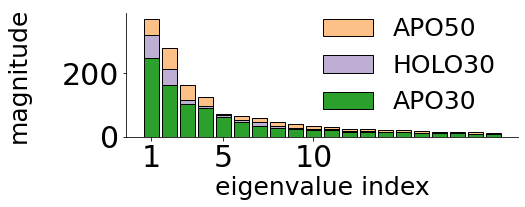

In [11]:

plt.figure(figsize=(8,3.5))

plt.bar(np.arange(0,20), reduce_t50a.pca.eigenvalues[0:20],  ec='k', alpha=1, label='APO50',  color=cols[2])
plt.bar(np.arange(0,20), reduce_t30h.pca.eigenvalues[0:20],  ec='k', alpha=1, label='HOLO30', color=cols[1])#'orange'  )
plt.bar(np.arange(0,20), reduce_t30a.pca.eigenvalues[0:20],  ec='k', alpha=1, label='APO30',  color=cols[0])#'tab:blue')

plt.legend(framealpha=0.0)
plt.xlabel('eigenvalue index',    fontsize=25) #weight='bold',
plt.ylabel('magnitude\n ',        fontsize=25) #weight='bold',

plt.xticks([0,4,9], [1,5,10])
sns.despine()
#plt.savefig(figpath + 'singular_values_pca.pdf', bbox_inches='tight')

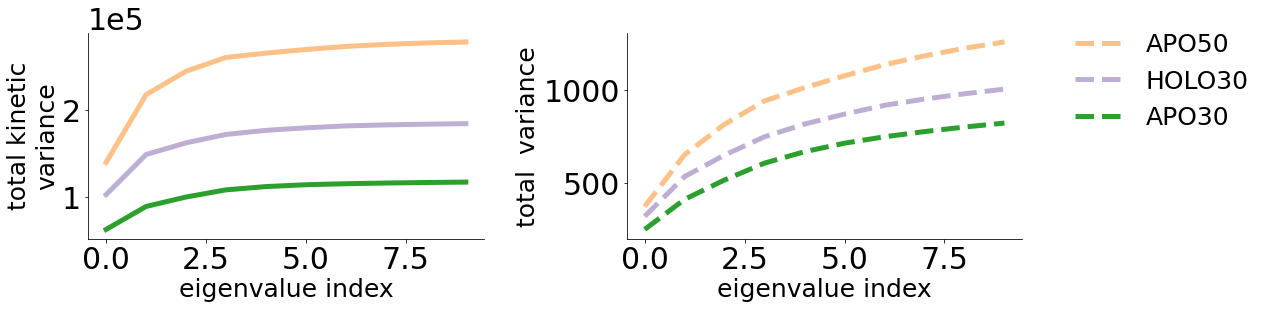

In [12]:
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=False, sharex=True)
labels=['APO30','HOLO30','APO50']
# eigval_t30a = fn_weighted_avg(pca_t30a.eigenvalues)[0:10]
# eigval_t30h = fn_weighted_avg(pca_t30h.eigenvalues)[0:10]
# eigval_t50a = fn_weighted_avg(pca_t50a.eigenvalues)[0:10]

eigval_t30a = reduce_t30a.pca.eigenvalues[0:10]
eigval_t30h = reduce_t30h.pca.eigenvalues[0:10]
eigval_t50a = reduce_t50a.pca.eigenvalues[0:10]
ax[0].plot(np.cumsum(eigval_t50a**2), linewidth=5, color=cols[2])
ax[0].plot(np.cumsum(eigval_t30h**2), linewidth=5, color=cols[1])#'orange'  )
ax[0].plot(np.cumsum(eigval_t30a**2), linewidth=5, color=cols[0])#'tab:blue')

ax[0].set_xlabel('eigenvalue index',      fontsize=25)
ax[0].set_ylabel("total kinetic\nvariance",  fontsize=25) 
ax[0].ticklabel_format(style='sci',scilimits=(0,5),axis='y')

ax[1].plot(np.cumsum(eigval_t50a), linewidth=5, label=labels[2], linestyle='dashed',  color=cols[2])
ax[1].plot(np.cumsum(eigval_t30h), linewidth=5, label=labels[1], linestyle='dashed',  color=cols[1])
ax[1].plot(np.cumsum(eigval_t30a), linewidth=5, label=labels[0], linestyle='dashed',  color=cols[0])
ax[1].set_xlabel('eigenvalue index', fontsize=25)
ax[1].set_ylabel('total  variance',  fontsize=25)

fig.legend(bbox_to_anchor=(1.2,.9), fontsize=25, framealpha=0.0)

#fig.delaxes(ax=ax[1])
plt.tight_layout()
sns.despine()
plt.savefig(figpath + 'variance.pdf', bbox_inches='tight')

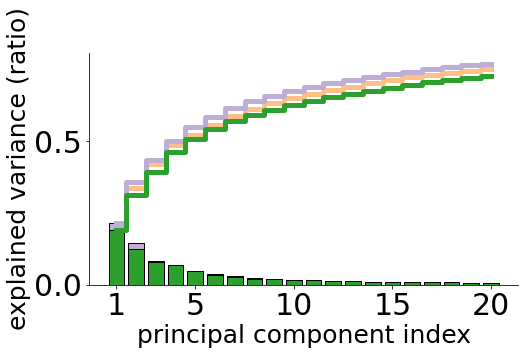

In [13]:
plt.figure(figsize=(8,5))
neig = 20

total_egnvalues = sum(reduce_t50a.pca.eigenvalues)
var_exp = [(i/total_egnvalues) for i in sorted(reduce_t50a.pca.eigenvalues, reverse=True)][0:neig]
cum_sum_exp = np.cumsum(var_exp)[0:neig]
plt.bar(range(0,len(var_exp)), var_exp, align='center', color=cols[2], ec='k') # label='bb-coord. A, T=50' 
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',      color=cols[2], lw=5) #label='Cumulative explained variance')

total_egnvalues = sum(reduce_t30h.pca.eigenvalues)
var_exp = [(i/total_egnvalues) for i in sorted(reduce_t30h.pca.eigenvalues, reverse=True)][0:neig]
cum_sum_exp = np.cumsum(var_exp)[0:neig]
plt.bar(range(0,len(var_exp)), var_exp, align='center',  color=cols[1], ec='k') #   label='bb-coord. H, T=30' ,
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',       color=cols[1], lw=5)#label='Cumulative explained variance')
#

total_egnvalues = sum(reduce_t30a.pca.eigenvalues)
var_exp = [(i/total_egnvalues) for i in sorted(reduce_t30a.pca.eigenvalues, reverse=True)][0:neig]
cum_sum_exp = np.cumsum(var_exp)[0:neig]
plt.bar(range(0,len(var_exp)), var_exp, align='center', color=cols[0], ec='k') # label='bb-coord. A, T=30', 
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',      color=cols[0], lw=5)#label='Cumulative explained variance')
#

plt.ylabel('explained variance (ratio)', fontsize=25)
plt.xlabel('principal component index',  fontsize=25)
plt.xticks([0,4,9,14,19], [1,5,10,15,20])


sns.despine()
plt.tight_layout()
# plt.savefig(figpath + 'explained_variance.pdf', bbox_inches='tight')

## Visualize difference motions

### visualize HOLO30-APO30 slow motions difference

In [14]:

proj_diff_t30hmin30a = (np.outer(reduce_t30h.trans-reduce_t30a.trans[:983], reduce_t30h.pc-reduce_t30a.pc) + 
                        reduce_t30a.data[:983,:].mean(axis=0).flatten())
coord_diff_t30hmin30a = proj_diff_t30hmin30a.reshape((983,1362,3))

t30h_minus_t30a = mda.Merge(reduce_t30a.proj.select_atoms('protein and backbone'))
t30h_minus_t30a.load_new(coord_diff_t30hmin30a, order="fac")
if SAVETRAJ:
    with MDAnalysis.Writer(outpath +"pca_t30h-t30a.dcd", t30h_minus_t30a.atoms.n_atoms) as W:
        for ts in t30h_minus_t30a.trajectory:
            W.write(t30h_minus_t30a.atoms)
    W.close()

    t30h_minus_t30a.trajectory[0]
    with MDAnalysis.Writer(outpath + "pca_t30h-t30a.pdb", t30h_minus_t30a.atoms.n_atoms) as W:
        W.write(t30h_minus_t30a.atoms)
    W.close()

t30h_minus_t30a = nv.show_mdanalysis(t30h_minus_t30a)
t30h_minus_t30a

NGLWidget(max_frame=982)

# visualize APO50-APO30 slow motions difference

In [15]:
proj_diff_t50amin30a = (np.outer(reduce_t50a.trans[:1003]-reduce_t30a.trans[:1003], reduce_t50a.pc-reduce_t30a.pc) + 
                        reduce_t30a.data[:983,:].mean(axis=0).flatten())
coord_diff_t50amin30a = proj_diff_t50amin30a.reshape((1003,1362,3))

t50a_minus_t30a = mda.Merge(reduce_t30a.proj.select_atoms('protein and backbone'))
t50a_minus_t30a.load_new(coord_diff_t50amin30a, order="fac")

if SAVETRAJ:
    with MDAnalysis.Writer(outpath +"pca_t50a-t30a.dcd", t50a_minus_t30a.atoms.n_atoms) as W:
        for ts in t50a_minus_t30a.trajectory:
            W.write(t50a_minus_t30a.atoms)
    W.close()
    t50a_minus_t30a.trajectory[0]
    with MDAnalysis.Writer(outpath + "pca_t50a-t30a.pdb", t50a_minus_t30a.atoms.n_atoms) as W:
        W.write(t50a_minus_t30a.atoms)
W.close()
t50a_minus_t30a = nv.show_mdanalysis(t50a_minus_t30a)
t50a_minus_t30a

NGLWidget(max_frame=1002)

## PCA using a single transformation for all three trajectories

In [16]:
data = np.concatenate([reduce_t30a.data, reduce_t30h.data, reduce_t50a.data], axis=0)
# if you don't need to project data, SKLEARN is optimal especially for computing PCA all at once on
# multiple trajectories to compare where each trajectory appears in PCA space. 

pcaskl_all = PCA(n_components=10, whiten=False)
pcaskl_all_fit = pcaskl_all.fit_transform(data)
labels = np.asarray(['APO30']*len(reduce_t30a.data) + ['HOLO30']*len(reduce_t30h.data)+ ['APO50']*len(reduce_t50a.data))



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: cm


<Figure size 1440x1440 with 0 Axes>

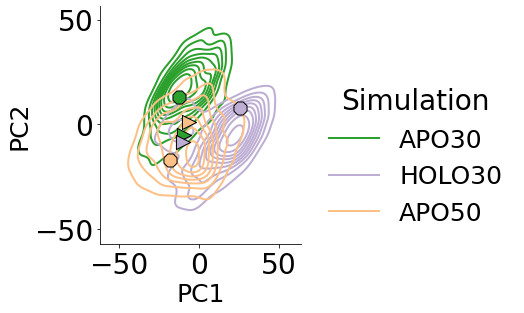

In [17]:
plt.rcParams['font.size'] = 28

name_list = ['APO30', 'HOLO30', 'APO50']
plt.figure(figsize=(20,20))
colors = cols #sns.color_palette("bright", len(name_list))
s0 = pcaskl_all_fit[:,0]
s1 = pcaskl_all_fit[:,1]
df_pca = pd.DataFrame({'PC1': s0, 'PC2': s1, 'Simulation': labels})

sns.displot(df_pca, x="PC1", y="PC2", hue="Simulation", kind="kde", palette=cols[0:3], levels=10)

for label, name, color in zip(pd.unique(labels), name_list, colors[0:3]):
    ix = np.where(labels == label)[0] 
    plt.gca().scatter(s0[ix[0]], s1[ix[0]],  color=color,  marker='>',  s=200, zorder=100, edgecolor='k')
    plt.gca().scatter(s0[ix[-1]],s1[ix[-1]], color=color,  marker='8',  s=200, zorder=100, edgecolor='k')


m1 = mlines.Line2D([], [], color='w', marker='>', markeredgewidth=.08, markeredgecolor='k',
                          markersize=130, label='Start of simulation')
m2 = mlines.Line2D([], [], color='w', marker='8',  markeredgewidth=.08, markeredgecolor='k',
                          markersize=130, label='End of simulation')

#plt.savefig(figpath + 'PCA_space_0_1.pdf')

<Figure size 1440x1440 with 0 Axes>

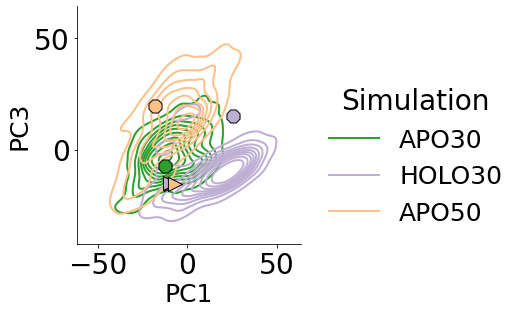

In [18]:

name_list = ['APO T30', 'HOLO T30', 'APO T50']
plt.figure(figsize=(20,20))
colors = cols[0:3] #sns.color_palette("bright", len(name_list))
s0 = pcaskl_all_fit[:,0]
s1 = pcaskl_all_fit[:,2]
df_pca = pd.DataFrame({'PC1': s0, 'PC3': s1, 'Simulation': labels})

sns.displot(df_pca, x="PC1", y="PC3", hue="Simulation", kind="kde", palette=cols[0:3], levels=10)

for label, name, color in zip(pd.unique(labels), name_list, colors):
    ix = np.where(labels == label)[0] 
    plt.gca().scatter(s0[ix[0]], s1[ix[0]],  color=color,  marker='>',  s=200, zorder=100, edgecolor='k')
    plt.gca().scatter(s0[ix[-1]],s1[ix[-1]], color=color,  marker='8',  s=200, zorder=100, edgecolor='k')


m1 = mlines.Line2D([], [], color='w', marker='>', markeredgewidth=.08, markeredgecolor='k',
                          markersize=130, label='Start of simulation')
m2 = mlines.Line2D([], [], color='w', marker='8',  markeredgewidth=.08, markeredgecolor='k',
                          markersize=130, label='End of simulation')

#plt.savefig(figpath + 'PCA_space_0_2.pdf')

<Figure size 1440x1440 with 0 Axes>

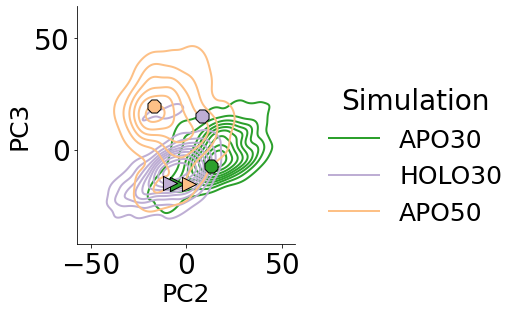

In [19]:
#plt.rcParams['font.size'] = 28
name_list = ['APO T30', 'HOLO T30', 'APO T50']
plt.figure(figsize=(20,20))
colors = cols[0:3] #sns.color_palette("bright", len(name_list))
s0 = pcaskl_all_fit[:,1]
s1 = pcaskl_all_fit[:,2]
df_pca = pd.DataFrame({'PC2': s0, 'PC3': s1, 'Simulation': labels})

sns.displot(df_pca, x="PC2", y="PC3", hue="Simulation", kind="kde", palette=cols[0:3], levels=10)

for label, name, color in zip(pd.unique(labels), name_list, colors):
    ix = np.where(labels == label)[0] 
    plt.gca().scatter(s0[ix[0]], s1[ix[0]],  color=color,  marker='>',  s=200, zorder=100, edgecolor='k')
    plt.gca().scatter(s0[ix[-1]],s1[ix[-1]], color=color,  marker='8',  s=200, zorder=100, edgecolor='k')


m1 = mlines.Line2D([], [], color='w', marker='>', markeredgewidth=.08, markeredgecolor='k',
                          markersize=130, label='Start of simulation')
m2 = mlines.Line2D([], [], color='w', marker='8',  markeredgewidth=.08, markeredgecolor='k',
                          markersize=130, label='End of simulation')

# plt.savefig(figpath + 'PCA_space_1_2.pdf')

In [20]:
def write_pml(name, n_comp):
    with open('%s.pml' %name, 'w') as f:
        f.write('viewport 3144, 1948\n')
        f.write('#viewport 1600,800\n')
        f.write('util.performance(0)\n')
        f.write('cmd.bg_color("white")\n')
        f.write('cmd.space("cmyk")\n')
        f.write('set ray_opaque_background, 0\n')
        f.write('set ray_trace_mode,1\n')
        f.write('set ray_trace_fog, 1\n')
        f.write('set ray_trace_gain, .2\n')
        f.write('#set ray_shadows, 0\n')
        f.write('set ortho = 1\n')
        f.write('set auto_zoom, 0\n')
        f.write('set auto_show_selections, 0\n')
        f.write('set light_count, 5\n')
        f.write('set ambient, 0.4\n')
        f.write('set antialias, 4\n')
        f.write('set surface_quality, 2\n')
        f.write('set cartoon_nucleic_acid_mode, 4\n')
        f.write('set cartoon_ring_mode, 0\n')
        f.write('set cartoon_tube_radius, 0.9\n')
        f.write('set cartoon_ladder_radius, 0.5\n')
        f.write('#set cartoon_cylindrical_helices, 1\n')
        f.write('set dash_width,4\n')
        f.write('set dash_color, gray60\n')
        f.write('set cartoon_loop_radius, 0.3\n')
        f.write('set cartoon_helix_radius, 3.0\n')
        f.write('set ribbon_trace_atoms, 4\n')
        f.write('set ribbon_radius, 0.5\n')
        f.write('set solvent_radius, 5.0\n')
        f.write('set cartoon_fancy_helices, 1\n')
        f.write('set defer_builds_mode, 3\n')
        f.write('set cartoon_transparency, .6\n')
        f.write('set label_size, 30\n')
        f.write('load {}.pdb, WT\n'.format(name))
        f.write('load {}.pdb, reference\n'.format(name))
        f.write('load_traj {}.dcd, WT , start=0, stop=-1, interval=10\n'.format(name))
        f.write('align reference, WT\n')
        f.write('set_view (\\n')
        f.write('     0.059968501,    0.868183672,    0.492196828,\ \n')
        f.write('     0.916177392,    0.147679657,   -0.372148842,\ \n')
        f.write('    -0.395868033,    0.473329425,   -0.786695063,\ \n')
        f.write('     0.000000000,   -0.000000000, -211.742935181,\ \n')
        f.write('    62.268287659,   48.440368652,   50.612606049,\ \n')
        f.write('   166.939743042,  256.546142578,  -20.000000000 ) \n')
        f.write('hide everything\n')
        f.write('######\n')
        f.write('show spheres, WT\n')
        f.write('set sphere_scale,.8\n')
        f.write('color gray, reference\n')
        f.write('#set sphere_transparency, .5\n')
        f.write('#smooth WT, 30, 5\n')
        f.write('split_states WT\n')
        f.write('for i,s in enumerate(cmd.get_object_list()[0::1]): cmd.alter(s,"b=%d"%i)\n')
        f.write('no=int(len(cmd.get_object_list()[0::1]))\n')
        f.write('spectrum b,paleyellow_lightteal_lightblue,  resid 1-454 , 1, 100\n')
        f.write('#join_states multi, WT_*, 0\n')
        f.write('ray 200, 200\n')
        f.write('#ray 1000, 800\n')
        f.write('png {}_comp_{}.png\n'.format(name, n_comp))
    f.close()


In [21]:
write_pml(outpath +'pca_t30a', 1)
write_pml(outpath +'pca_t30h', 1)
write_pml(outpath +'pca_t50a', 1)

In [61]:
# # you need to have pymol installed to exectute this!
# ! pymol -c  overlay_t30a.pml
# ! pymol -c  overlay_t30h.pml
# ! pymol -c  overlay_t50a.pml
